In [45]:
# Tratamiento de datos
import numpy as np
import pandas as pd
import snscrape.modules.twitter as sntwitter
import re, string, warnings


# Graficacion
from matplotlib import style
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento y modelado
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.spatial.distance import cosine
import nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


# Ignorar warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /home/cruv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
def similitud_coseno(a,b):
    return 1-cosine(a,b)


def formateo_texto(text):
    
    # Texto a minúsculas
    new_text = text.lower()
    # Eliminación de páginas web
    new_text = re.sub('http\S+', ' ', new_text)
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    new_text = re.sub(regex , ' ', new_text)
    # Eliminación de números
    new_text = re.sub("\d+", ' ', new_text)
    # Eliminación de espacios en blanco múltiples
    new_text = re.sub("\\s+", ' ', new_text)
    # Tokenización por palabras individuales
    new_text = new_text.split(sep = ' ')
    # Eliminación de tokens con una longitud < 2
    new_text = [token for token in new_text if len(token) > 1]
    
    return(new_text)

In [24]:
%%time

# Parámetros
tweets_list = []
max_tweets = 1000


users_name = ['BarackObama','JoeBiden','Zendaya']

for n, k in enumerate(users_name):
    for i,tweet in enumerate(sntwitter.TwitterSearchScraper('from:{}'.format(users_name[n])).get_items()):
            if i>max_tweets-1:
                break
            tweets_list.append([tweet.user.username, tweet.date, tweet.id, tweet.content])

CPU times: user 2.13 s, sys: 57.8 ms, total: 2.19 s
Wall time: 1min 11s


In [25]:
df_tweets = pd.DataFrame (tweets_list,columns = ['autor', 'fecha', 'id', 'texto'])
df_tweets['fecha'] = pd.to_datetime(df_tweets['fecha'])
df_tweets.head()

,autor,fecha,id,texto
0,BarackObama,2022-11-29 17:01:00+00:00,1597636758505934848,Michelle and I started the @ObamaFoundation to...
1,BarackObama,2022-11-26 16:31:21+00:00,1596542133925658624,"Last month, I spoke with some of the incredibl..."
2,BarackObama,2022-11-24 14:59:12+00:00,1595794166830682112,One of my favorite White House traditions was ...
3,BarackObama,2022-11-24 13:30:27+00:00,1595771830878576642,Wishing everyone a happy Thanksgiving! As we c...
4,BarackObama,2022-11-23 20:00:49+00:00,1595507681749569559,"But voters in some states—including Florida, T..."


In [26]:
print('Número de tweets @Barack Obama: ', len(df_tweets[df_tweets['autor']=='BarackObama']))
print('Número de tweets @Joe Biden: ', len(df_tweets[df_tweets['autor']=='JoeBiden']))
print('Número de tweets @Zendaya: ', len(df_tweets[df_tweets['autor']=='Zendaya']))

Número de tweets @Barack Obama:  1000
Número de tweets @Joe Biden:  1000
Número de tweets @Zendaya:  1000


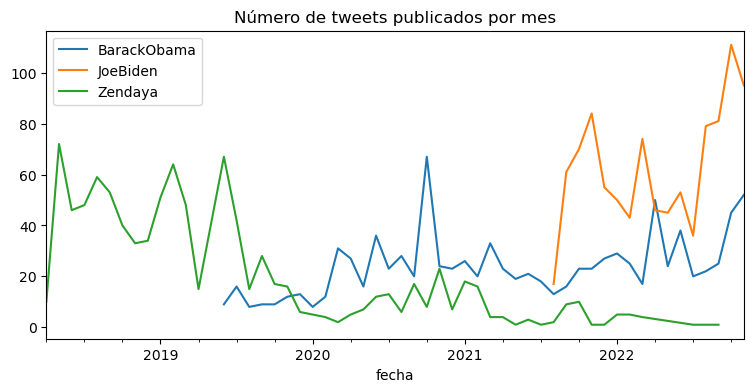

In [27]:
fig, ax = plt.subplots(figsize=(9,4))

for autor in df_tweets.autor.unique():
    df_temp = df_tweets[df_tweets['autor'] == autor].copy()
    df_temp['fecha'] = pd.to_datetime(df_temp['fecha'].dt.strftime('%Y-%m'))
    df_temp = df_temp.groupby(df_temp['fecha']).size()
    df_temp.plot(label=autor, ax=ax)

ax.set_title('Número de tweets publicados por mes')
ax.legend();

In [30]:
df_tweets['texto_formateado'] = df_tweets['texto'].apply(lambda x: formateo_texto(x))
df_tweets[['texto', 'texto_formateado']].head()

,texto,texto_formateado
0,Michelle and I started the @ObamaFoundation to...,"[michelle, and, started, the, obamafoundation,..."
1,"Last month, I spoke with some of the incredibl...","[last, month, spoke, with, some, of, the, incr..."
2,One of my favorite White House traditions was ...,"[one, of, my, favorite, white, house, traditio..."
3,Wishing everyone a happy Thanksgiving! As we c...,"[wishing, everyone, happy, thanksgiving, as, w..."
4,"But voters in some states—including Florida, T...","[but, voters, in, some, states—including, flor..."


In [31]:
# Unnest de la columna texto_tokenizado
tweets_tidy = df_tweets.explode(column='texto_formateado')
tweets_tidy = tweets_tidy.drop(columns='texto')
tweets_tidy = tweets_tidy.rename(columns={'texto_formateado':'token'})
tweets_tidy.head(3)

,autor,fecha,id,token
0,BarackObama,2022-11-29 17:01:00+00:00,1597636758505934848,michelle
0,BarackObama,2022-11-29 17:01:00+00:00,1597636758505934848,and
0,BarackObama,2022-11-29 17:01:00+00:00,1597636758505934848,started


In [32]:
print('--------------------------')
print('Palabras totales por autor')
print('--------------------------')
tweets_tidy.groupby(by='autor')['token'].count()

--------------------------
Palabras totales por autor
--------------------------


autor
BarackObama    35325
JoeBiden       30627
Zendaya         7742
Name: token, dtype: int64

In [34]:
print('----------------------------')
print('Palabras distintas por autor')
print('----------------------------')
tweets_tidy.groupby(by='autor')['token'].nunique()

----------------------------
Palabras distintas por autor
----------------------------


autor
BarackObama    4429
JoeBiden       3225
Zendaya        2075
Name: token, dtype: int64

In [35]:
temp_df = pd.DataFrame(tweets_tidy.groupby(by = ["autor", "id"])["token"].count())
temp_df.reset_index().groupby("autor")["token"].agg(['mean', 'std'])

,mean,std
autor,,
BarackObama,35.325,9.770406
JoeBiden,30.627,11.865440
Zendaya,7.742,8.611945


In [36]:
tweets_tidy.groupby(['autor','token'])['token'] \
 .count() \
 .reset_index(name='count') \
 .groupby('autor') \
 .apply(lambda x: x.sort_values('count', ascending=False).head(5))

autor token  count
autor                                     
BarackObama 3841  BarackObama   the   1703
            3914  BarackObama    to   1606
            173   BarackObama   and   1345
            2649  BarackObama    of    849
            1916  BarackObama    in    585
JoeBiden    7228     JoeBiden   the   1684
            7274     JoeBiden    to   1240
            4554     JoeBiden   and    974
            5801     JoeBiden    in    640
            6273     JoeBiden    of    593
Zendaya     9390      Zendaya    to    221
            9621      Zendaya   you    210
            9339      Zendaya   the    203
            7720      Zendaya   and    148
            8765      Zendaya    my    144

In [39]:
stop_words = list(stopwords.words('english'))
# Se añade la stoprword: amp, ax, ex
stop_words.extend(("amp", "xa", "xe"))
print(stop_words[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [40]:
# Filtrado para excluir stopwords
# ==============================================================================
tweets_tidy = tweets_tidy[~(tweets_tidy["token"].isin(stop_words))]

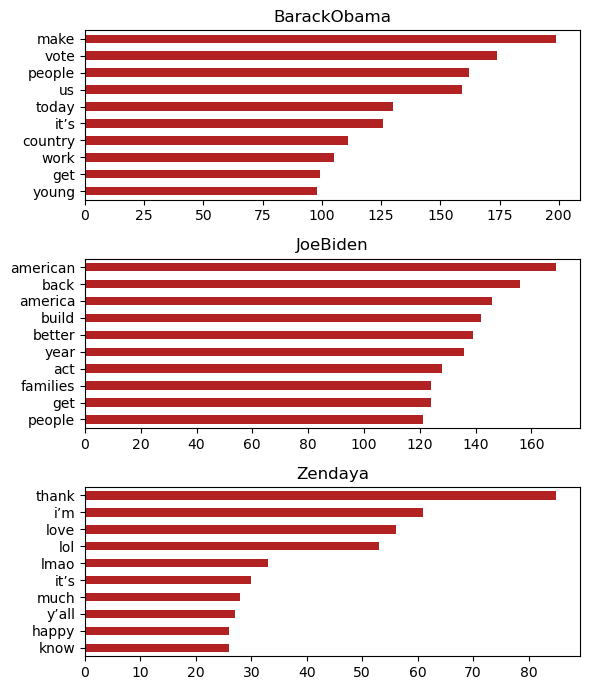

In [41]:
# Top 10 palabras por autor (sin stopwords)
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1,figsize=(6, 7))
for i, autor in enumerate(tweets_tidy.autor.unique()):
    df_temp = tweets_tidy[tweets_tidy.autor == autor]
    counts  = df_temp['token'].value_counts(ascending=False).head(10)
    counts.plot(kind='barh', color='firebrick', ax=axs[i])
    axs[i].invert_yaxis()
    axs[i].set_title(autor)

fig.tight_layout()

In [42]:
# Pivotado de datos
# ==============================================================================
tweets_pivot = tweets_tidy.groupby(["autor","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="autor", values= "count")
tweets_pivot.columns.name = None

In [47]:
# Test de correlación (coseno) por el uso y frecuencia de palabras
tweets_pivot.corr(method=similitud_coseno)

,BarackObama,JoeBiden,Zendaya
BarackObama,1.000000,0.689549,0.538549
JoeBiden,0.689549,1.000000,0.420472
Zendaya,0.538549,0.420472,1.000000


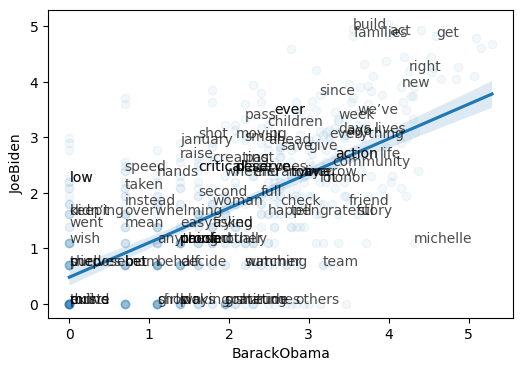

In [50]:
# Gráfico de correlación
# ==============================================================================
f, ax = plt.subplots(figsize=(6, 4))
temp = tweets_pivot.dropna()
sns.regplot(
    x  = np.log(temp.BarackObama),
    y  = np.log(temp.JoeBiden),
    scatter_kws =  {'alpha': 0.05},
    ax = ax
);
for i in np.random.choice(range(temp.shape[0]), 100):
    ax.annotate(
        text  = temp.index[i],
        xy    = (np.log(temp.BarackObama[i]), np.log(temp.JoeBiden[i])),
        alpha = 0.7
    )

In [51]:
# Número de palabras comunes
# ==============================================================================
palabras_barack = set(tweets_tidy[tweets_tidy.autor == 'BarackObama']['token'])
palabras_joe = set(tweets_tidy[tweets_tidy.autor == 'JoeBiden']['token'])
palabras_zendaya = set(tweets_tidy[tweets_tidy.autor == 'Zendaya']['token'])

print(f"Palabras comunes entre Barack Obama y Joe Biden: {len(palabras_barack.intersection(palabras_joe))}")
print(f"Palabras comunes entre Barack Obama y Zendaya: {len(palabras_barack.intersection(palabras_zendaya))}")
print(f"Palabras comunes entre Joe Biden y Zendaya: {len(palabras_joe.intersection(palabras_zendaya))}")

Palabras comunes entre Barack Obama y Joe Biden: 1708
Palabras comunes entre Barack Obama y Zendaya: 711
Palabras comunes entre Joe Biden y Zendaya: 585


In [57]:
# Cálculo del log of odds ratio de cada palabra (elonmusk vs mayoredlee)
# ==============================================================================
# Pivotaje y despivotaje
tweets_pivot = tweets_tidy.groupby(["autor","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="autor", values= "count")

tweets_pivot = tweets_pivot.fillna(value=0)
tweets_pivot.columns.name = None

tweets_unpivot = tweets_pivot.melt(value_name='n', var_name='autor', ignore_index=False)
tweets_unpivot = tweets_unpivot.reset_index()

# Selección de los autores elonmusk y mayoredlee
tweets_unpivot = tweets_unpivot[tweets_unpivot.autor.isin(['BarackObama', 'JoeBiden'])]

# Se añade el total de palabras de cada autor
tweets_unpivot = tweets_unpivot.merge(
                    tweets_tidy.groupby('autor')['token'].count().rename('N'),
                    how = 'left',
                    on  = 'autor'
                 )

# Cálculo de odds y log of odds de cada palabra
tweets_logOdds = tweets_unpivot.copy()
tweets_logOdds['odds'] = (tweets_logOdds.n + 1) / (tweets_logOdds.N + 1)
tweets_logOdds = tweets_logOdds[['token', 'autor', 'odds']] \
                    .pivot(index='token', columns='autor', values='odds')
tweets_logOdds.columns.name = None

tweets_logOdds['log_odds']     = np.log(tweets_logOdds.BarackObama/tweets_logOdds.JoeBiden)
tweets_logOdds['abs_log_odds'] = np.abs(tweets_logOdds.log_odds)

# Si el logaritmo de odds es mayor que cero, significa que es una palabra con
# mayor probabilidad de ser de Elon Musk. Esto es así porque el ratio sea ha
# calculado como elonmusk/mayoredlee.
tweets_logOdds['autor_frecuente'] = np.where(tweets_logOdds.log_odds > 0,
                                              "BarackObama",
                                              "JoeBiden")

In [58]:
print('-----------------------------------')
print('Top 10 palabras más diferenciadoras')
print('-----------------------------------')
tweets_logOdds.sort_values('abs_log_odds', ascending=False).head(10)

-----------------------------------
Top 10 palabras más diferenciadoras
-----------------------------------


,BarackObama,JoeBiden,log_odds,abs_log_odds,autor_frecuente
token,,,,,
tax,0.000051,0.002600,-3.924928,3.924928,JoeBiden
prices,0.000051,0.002600,-3.924928,3.924928,JoeBiden
maga,0.000051,0.002261,-3.785166,3.785166,JoeBiden
obamafoundation,0.002464,0.000057,3.774915,3.774915,BarackObama
costs,0.000154,0.006105,-3.679805,3.679805,JoeBiden
joebiden,0.002002,0.000057,3.567276,3.567276,BarackObama
chicago,0.001694,0.000057,3.400221,3.400221,BarackObama
pro,0.000051,0.001526,-3.392123,3.392123,JoeBiden
insulin,0.000051,0.001470,-3.354383,3.354383,JoeBiden


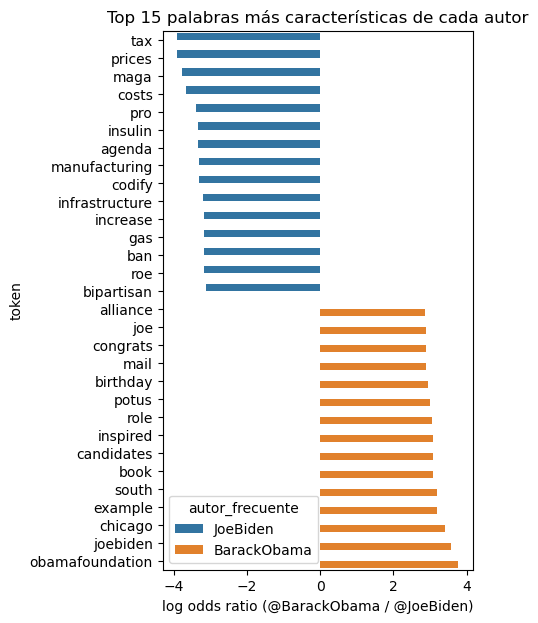

In [59]:
# Top 15 palabras más características de cada autor
# ==============================================================================

top_30 = tweets_logOdds[['log_odds', 'abs_log_odds', 'autor_frecuente']] \
        .groupby('autor_frecuente') \
        .apply(lambda x: x.nlargest(15, columns='abs_log_odds').reset_index()) \
        .reset_index(drop=True) \
        .sort_values('log_odds')

f, ax = plt.subplots(figsize=(4, 7))
sns.barplot(
    x    = 'log_odds',
    y    = 'token',
    hue  = 'autor_frecuente',
    data = top_30,
    ax   = ax
)
ax.set_title('Top 15 palabras más características de cada autor')
ax.set_xlabel('log odds ratio (@BarackObama / @JoeBiden)');

In [60]:
# Cálculo term-frecuency (tf)
# ==============================================================================
tf = tweets_tidy.copy()
# Número de veces que aparece cada término en cada tweet
tf = tf.groupby(["id", "token"])["token"].agg(["count"]).reset_index()
# Se añade una columna con el total de términos por tweet
tf['total_count'] = tf.groupby('id')['count'].transform(sum)
# Se calcula el tf
tf['tf'] = tf["count"] / tf["total_count"]
tf.sort_values(by = "tf").head(3)

,id,token,count,total_count,tf
21049,1468260275820376069,keep,1,33,0.030303
21050,1468260275820376069,lower,1,33,0.030303
21048,1468260275820376069,insurance,1,33,0.030303


In [61]:
# Inverse document frequency
# ==============================================================================
idf = tweets_tidy.copy()
total_documents = idf["id"].drop_duplicates().count()
# Número de documentos (tweets) en los que aparece cada término
idf = idf.groupby(["token", "id"])["token"].agg(["count"]).reset_index()
idf['n_documentos'] = idf.groupby('token')['count'].transform(sum)
# Cálculo del idf
idf['idf'] = np.log(total_documents / idf['n_documentos'])
idf = idf[["token","n_documentos", "idf"]].drop_duplicates()
idf.sort_values(by="idf").head(3)

,token,n_documentos,idf
21324,make,319,2.239842
25768,people,292,2.328280
36966,vote,277,2.381016


In [62]:
# Term Frequency - Inverse Document Frequency
# ==============================================================================
tf_idf = pd.merge(left=tf, right=idf, on="token")
tf_idf["tf_idf"] = tf_idf["tf"] * tf_idf["idf"]
tf_idf.sort_values(by="id").head()

,id,token,count,total_count,tf,n_documentos,idf,tf_idf
0,988917845181399041,lmao,1,3,0.333333,33,4.508526,1.502842
34,988917845181399041,zendayasabrina,1,3,0.333333,2,7.311886,2.437295
33,988917845181399041,meechonmars,1,3,0.333333,1,8.005033,2.668344
36,988918576609353728,done,1,2,0.500000,55,3.997700,1.998850
91,988918576609353728,zendayascuris,1,2,0.500000,3,6.906421,3.453211


In [64]:
# Reparto train y test
# ==============================================================================
datos_X = df_tweets.loc[df_tweets.autor.isin(['BarackObama', 'JoeBiden']), 'texto']
datos_y = df_tweets.loc[df_tweets.autor.isin(['BarackObama', 'JoeBiden']), 'autor']

X_train, X_test, y_train, y_test = train_test_split(
    datos_X,
    datos_y,
    test_size = 0.2,
    random_state = 123
)

In [65]:
value, counts = np.unique(y_train, return_counts=True)
print(dict(zip(value, 100 * counts / sum(counts))))
value, counts = np.unique(y_test, return_counts=True)
print(dict(zip(value, 100 * counts / sum(counts))))

{'BarackObama': 49.5625, 'JoeBiden': 50.4375}
{'BarackObama': 51.75, 'JoeBiden': 48.25}


In [66]:
# Creación de la matriz tf-idf
# ==============================================================================
tfidf_vectorizador = TfidfVectorizer(
                        tokenizer  = formateo_texto,
                        min_df     = 3,
                        stop_words = stop_words
                    )
tfidf_vectorizador.fit(X_train)

TfidfVectorizer(min_df=3,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<function formateo_texto at 0x7fa7ed111f70>)

In [67]:
tfidf_train = tfidf_vectorizador.transform(X_train)
tfidf_test  = tfidf_vectorizador.transform(X_test)

In [69]:
print(f" Número de tokens creados: {len(tfidf_vectorizador.get_feature_names())}")
print(tfidf_vectorizador.get_feature_names()[:10])

 Número de tokens creados: 1790
['ability', 'able', 'abortion', 'abroad', 'absolutely', 'aca', 'accelerate', 'access', 'accomplished', 'accountability']


In [70]:
# Entrenamiento del modelo SVM
# ==============================================================================
modelo_svm_lineal = svm.SVC(kernel= "linear", C = 1.0)
modelo_svm_lineal.fit(X=tfidf_train, y= y_train)

SVC(kernel='linear')

In [71]:
# Grid de hiperparámetros
# ==============================================================================
param_grid = {'C': np.logspace(-5, 3, 10)}

# Búsqueda por validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = svm.SVC(kernel= "linear"),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = -1,
        cv         = 5, 
        verbose    = 0,
        return_train_score = True
      )

# Se asigna el resultado a _ para que no se imprima por pantalla
_ = grid.fit(X = tfidf_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)

,param_C,mean_test_score,std_test_score,mean_train_score,std_train_score
5,0.278256,0.886250,0.025739,0.944219,0.003337
6,2.154435,0.883750,0.013750,0.990469,0.001515
7,16.681005,0.868750,0.013835,0.999375,0.000312
8,129.154967,0.846250,0.013317,1.000000,0.000000
9,1000.0,0.844375,0.011075,1.000000,0.000000
4,0.035938,0.546250,0.023750,0.570156,0.035898
0,0.00001,0.504375,0.001531,0.504375,0.000383
1,0.000077,0.504375,0.001531,0.504375,0.000383
2,0.000599,0.504375,0.001531,0.504375,0.000383
3,0.004642,0.504375,0.001531,0.504375,0.000383


In [72]:
# Grid de hiperparámetros
# ==============================================================================
param_grid = {'C': np.logspace(-5, 3, 10)}

# Búsqueda por validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = svm.SVC(kernel= "linear"),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = -1,
        cv         = 5, 
        verbose    = 0,
        return_train_score = True
      )

# Se asigna el resultado a _ para que no se imprima por pantalla
_ = grid.fit(X = tfidf_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)

,param_C,mean_test_score,std_test_score,mean_train_score,std_train_score
5,0.278256,0.886250,0.025739,0.944219,0.003337
6,2.154435,0.883750,0.013750,0.990469,0.001515
7,16.681005,0.868750,0.013835,0.999375,0.000312
8,129.154967,0.846250,0.013317,1.000000,0.000000
9,1000.0,0.844375,0.011075,1.000000,0.000000
4,0.035938,0.546250,0.023750,0.570156,0.035898
0,0.00001,0.504375,0.001531,0.504375,0.000383
1,0.000077,0.504375,0.001531,0.504375,0.000383
2,0.000599,0.504375,0.001531,0.504375,0.000383
3,0.004642,0.504375,0.001531,0.504375,0.000383


In [74]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

modelo_final = grid.best_estimator_

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'C': 0.2782559402207126} : 0.8862499999999999 accuracy


In [75]:
# Error predicciones test
# ==============================================================================
predicciones_test = modelo_final.predict(X=tfidf_test)

print("-------------")
print("Error de test")
print("-------------")

print(f"Número de clasificaciones erróneas de un total de {tfidf_test.shape[0]} " \
      f"clasificaciones: {(y_test != predicciones_test).sum()}"
)
print(f"% de error: {100*(y_test != predicciones_test).mean()}")

print("")
print("-------------------")
print("Matriz de confusión")
print("-------------------")
pd.DataFrame(confusion_matrix(y_true = y_test, y_pred= predicciones_test),
             columns= ["Barack Obama", "Joe Biden"],
             index = ["Barack Obama", "Joe Biden"])

-------------
Error de test
-------------
Número de clasificaciones erróneas de un total de 400 clasificaciones: 55
% de error: 13.750000000000002

-------------------
Matriz de confusión
-------------------


,Barack Obama,Joe Biden
Barack Obama,189,18
Joe Biden,37,156


In [76]:
# Error predicciones test
# ==============================================================================
predicciones_test = modelo_final.predict(X=tfidf_test)

print("-------------")
print("Error de test")
print("-------------")

print(f"Número de clasificaciones erróneas de un total de {tfidf_test.shape[0]} " \
      f"clasificaciones: {(y_test != predicciones_test).sum()}"
)
print(f"% de error: {100*(y_test != predicciones_test).mean()}")

print("")
print("-------------------")
print("Matriz de confusión")
print("-------------------")
pd.DataFrame(confusion_matrix(y_true = y_test, y_pred= predicciones_test),
             columns= ["Elon Musk", "Mayor Ed Lee"],
             index = ["Elon Musk", "Mayor Ed Lee"])

-------------
Error de test
-------------
Número de clasificaciones erróneas de un total de 400 clasificaciones: 55
% de error: 13.750000000000002

-------------------
Matriz de confusión
-------------------


,Elon Musk,Mayor Ed Lee
Elon Musk,189,18
Mayor Ed Lee,37,156


In [77]:
# Descarga lexicon sentimientos
# ==============================================================================
lexicon = pd.read_table(
            'https://raw.githubusercontent.com/fnielsen/afinn/master/afinn/data/AFINN-en-165.txt',
            names = ['termino', 'sentimiento']
          )
lexicon.head()

,termino,sentimiento
0,abandon,-2
1,abandoned,-2
2,abandons,-2
3,abducted,-2
4,abduction,-2


In [78]:


# Sentimiento promedio de cada tweet
# ==============================================================================
tweets_sentimientos = pd.merge(
                            left     = tweets_tidy,
                            right    = lexicon,
                            left_on  = "token", 
                            right_on = "termino",
                            how      = "inner"
                      )

tweets_sentimientos = tweets_sentimientos.drop(columns = "termino")

# Se suman los sentimientos de las palabras que forman cada tweet.
tweets_sentimientos = tweets_sentimientos[["autor","fecha", "id", "sentimiento"]] \
                      .groupby(["autor", "fecha", "id"])\
                      .sum().reset_index()
tweets_sentimientos.head()



,autor,fecha,id,sentimiento
0,BarackObama,2019-06-11 16:15:32+00:00,1138479890389458945,19
1,BarackObama,2019-06-16 13:47:03+00:00,1140254463183249409,10
2,BarackObama,2019-06-16 18:08:20+00:00,1140320216041316352,2
3,BarackObama,2019-06-18 18:17:55+00:00,1141047405560942592,3
4,BarackObama,2019-06-19 17:00:44+00:00,1141390367352401920,3


In [79]:
def perfil_sentimientos(df):
    print(autor)
    print("=" * 12)
    print(f"Positivos: {round(100 * np.mean(df.sentimiento > 0), 2)}")
    print(f"Neutros  : {round(100 * np.mean(df.sentimiento == 0), 2)}")
    print(f"Negativos: {round(100 * np.mean(df.sentimiento < 0), 2)}")
    print(" ")

for autor, df in tweets_sentimientos.groupby("autor"):
    perfil_sentimientos(df)

BarackObama
Positivos: 82.55
Neutros  : 4.47
Negativos: 12.98
 
JoeBiden
Positivos: 73.03
Neutros  : 4.53
Negativos: 22.43
 
Zendaya
Positivos: 80.4
Neutros  : 2.23
Negativos: 17.37
 


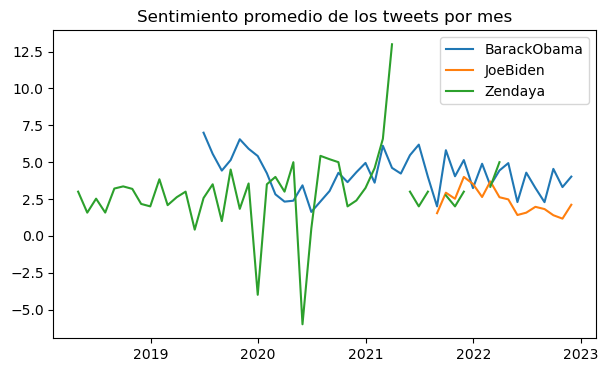

In [80]:
fig, ax = plt.subplots(figsize=(7, 4)) 

for autor in tweets_sentimientos.autor.unique():
    df = tweets_sentimientos[tweets_sentimientos.autor == autor].copy()
    df = df.set_index("fecha")
    df = df[['sentimiento']].resample('1M').mean()
    ax.plot(df.index, df.sentimiento, label=autor)

ax.set_title("Sentimiento promedio de los tweets por mes")
ax.legend();